In [62]:
import pandas as pd
import nltk
from nltk.tokenize.toktok import ToktokTokenizer
import spacy 
from datetime import datetime
import re
import string
from collections import Counter
import itertools
import networkx as nx
import unicodedata
import random
from gensim import corpora

from netwulf import visualize

### Sentiment analysis
from textblob import TextBlob
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

### Load Twitter data

In [2]:
df = pd.read_pickle("Raw_Tweets.pkl") # Load your tweets
df.head()

,tweetid,userid,date,lang,text,tweet_type,friends_count,followers_count,statuses_count,mentionid,rt_userid,rt_tweetid,qtd_userid,qtd_text,qtd_tweetid
12221,1221208309728006145,418859255,Sat Jan 25 23:08:44 +0000 2020,en,"RT @DepSecHargan: Every year in the US, 34,800...",retweeted_tweet_without_comment,638,1837,17778,[920035992073064450],9.200360e+17,1.221208e+18,NaN,NaN,NaN
28315,1221213073652043776,14499829,Sat Jan 25 23:27:40 +0000 2020,en,WHO’s risk assessment of the new #coronavirus ...,original,1743,5196950,46697,[],NaN,NaN,NaN,NaN,NaN
6092,1222281847163576321,1135486501,Tue Jan 28 22:14:35 +0000 2020,en,#FYI: 50 million are under travel restrictions...,original,950,27025,11145,[9624742],NaN,NaN,NaN,NaN,NaN
13618,1222289121118511104,117793973,Tue Jan 28 22:43:30 +0000 2020,en,What should I do if I have traveled to China a...,original,1236,5860,4578,[],NaN,NaN,NaN,NaN,NaN
19205,1222285279047843843,1465196934,Tue Jan 28 22:28:14 +0000 2020,en,Disease outbreaks can result in misinformation...,original,1946,3581,4636,[],NaN,NaN,NaN,NaN,NaN


In [6]:
df = df[~df.text.isna()]

### Preprocessing Twitter Data

In [7]:
# remove HTML links, mentions, hashtags, and special characters
# choose functions that suit your neeeds

def strip_links(text):
    link_regex    = re.compile('((https?):((//)|(\\\\))+([\w\d:#@%/;$()~_?\+-=\\\.&](#!)?)*)', re.DOTALL)
    links         = re.findall(link_regex, text)
    for link in links:
        text = text.replace(link[0], ' ')    
    return text

def strip_mentions(text):
    entity_prefixes = ['@']
    for separator in  string.punctuation:
        if separator not in entity_prefixes :
            text = text.replace(separator,' ')
    words = []
    for word in text.split():
        word = word.strip()
        if word:
            if word[0] not in entity_prefixes:
                words.append(word)
    return ' '.join(words)

def strip_hashtags(text):
    entity_prefixes = ['#']
    for separator in  string.punctuation:
        if separator not in entity_prefixes :
            text = text.replace(separator,' ')
    words = []
    for word in text.split():
        word = word.strip()
        if word:
            if word[0] not in entity_prefixes:
                words.append(word)
    return ' '.join(words)
        
def remove_special_characters(text, remove_digits=False):
    pattern = r'[^a-zA-z0-9\s]' if not remove_digits else r'[^a-zA-z\s]'
    text = re.sub(pattern, '', text)
    text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
    return text

In [8]:
# generate a random tweet: 
i = random.choice(df.index)
tweet = df.loc[i, 'text']
print(tweet)

.@POTUS signed an executive order to develop a task force to help address the epidemic of missing and murdered Indi… https://t.co/SVKqareops


In [9]:
tweet = strip_links(tweet)
tweet = strip_mentions(tweet)
tweet = strip_hashtags(tweet)
tweet = remove_special_characters(tweet)
print(tweet)

signed an executive order to develop a task force to help address the epidemic of missing and murdered Indi


In [10]:
def process_tweets(tweet):
    tweet = strip_links(tweet)
    tweet = strip_mentions(tweet)
    tweet = strip_hashtags(tweet)
    tweet = remove_special_characters(tweet)
    return tweet

In [11]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /Users/herbert/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [12]:
df.loc[:, 'text'] = df.text.apply(process_tweets)
df.text

12221     RT Every year in the US 34 800 women and men a...
28315     WHOs risk assessment of the new coronavirus 20...
6092      FYI 50 million are under travel restrictions i...
13618     What should I do if I have traveled to China a...
19205     Disease outbreaks can result in misinformation...
                                ...                        
116861    Were moving in the wrong direction amp theres ...
118583    DHHR reports as of 10 00 a m October 24 2020 t...
159427    We must tackle this pandemic together We can s...
159487    RT Today is a good day to talk with your teen ...
166622    RT Today is Drug TakeBackDay You can help figh...
Name: text, Length: 59887, dtype: object

### Stemming/Lemming

In [17]:
# Stemming / Lemming

### loading a spacy language model
# python -m spacy download en_core_web_sm
# https://spacy.io/models/en

nlp = spacy.load('en_core_web_sm') 

def simple_stemmer(text):
    ps = nltk.porter.PorterStemmer()
    text = ' '.join([ps.stem(word) for word in text.split()])
    return text

def lemmatize_text(text):
    text = nlp(text)
    text = ' '.join([word.lemma_ if word.lemma_ != '-PRON-' else word.text for word in text])
    return text

In [14]:
print(tweet)
print('------\nstemmed tweet:')
print(simple_stemmer(tweet))
print('------\nlemmatized tweet:')
print(lemmatize_text(tweet))

signed an executive order to develop a task force to help address the epidemic of missing and murdered Indi
------
stemmed tweet:
sign an execut order to develop a task forc to help address the epidem of miss and murder indi
------
lemmatized tweet:
sign an executive order to develop a task force to help address the epidemic of miss and murder Indi


In [ ]:
import pandas as pd

articles   = A = pd.read_csv("[insert_file_name_here.csv]", columns=["article"])
paragraphs = P = A.article.apply(lambda x: x.split("/n"))
sentences  = S = A.article.apply(lambda x: x.split(" "))

### Tokenizing and Corpus Creation

In [18]:
### Run this the first time
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/herbert/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [19]:
tokenizer = ToktokTokenizer()
stopword_list = nltk.corpus.stopwords.words('english')

def remove_stopwords(text, is_lower_case=False):
    tokens = tokenizer.tokenize(text)
    tokens = [token.strip() for token in tokens]
    if is_lower_case:
        filtered_tokens = [token for token in tokens if token not in stopword_list]
    else:
        filtered_tokens = [token for token in tokens if token.lower() not in stopword_list]
    filtered_text = ' '.join(filtered_tokens)    
    return filtered_text

In [33]:
%%time
#Create corupus of all words
words_corpus = []
for elem in df.text.iloc[1:100]:
    # remove stop words
    elem = remove_stopwords(elem)
    # lemmatize text
    elem = lemmatize_text(elem)
    words_corpus.append(elem.lower().split())
print(len(words_corpus))

dictionary = corpora.Dictionary(words_corpus)
print(len(dictionary))

99
563
CPU times: user 413 ms, sys: 3.55 ms, total: 416 ms
Wall time: 417 ms


#### Apply this to the entire dataframe

In [38]:
%%time
df["text_processed"] = df.text.apply(remove_stopwords)
df["text_processed"] = df.text_processed.apply(lemmatize_text)
df["text_processed"] = df.text_processed.apply(lambda x: x.lower().split())

CPU times: user 4min 28s, sys: 1.06 s, total: 4min 29s
Wall time: 4min 30s


# RUN UNTIL HERE TO FOLLOW DURING CLASS

In [43]:
df["text_tups"] = df.text_processed.apply(lambda x: list(itertools.combinations(x, 2)))
all_tups = [item for sublist in df.text_tups.values for item in sublist]
all_tups = Counter(all_tups)


In [ ]:
word_edges = all_tups.most_common(40)
word_edges = [(w[0][0], w[0][1], w[1] ) for w in word_edges]

In [60]:
G = nx.Graph()
G.add_weighted_edges_from(word_edges)

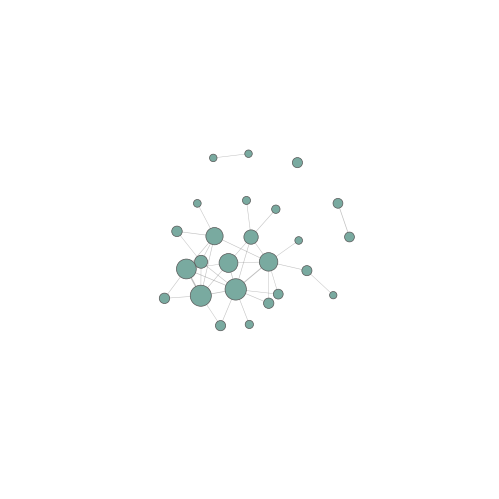

In [64]:
stylized_network, config = visualize(G,)

## LDA Topic Modeling & Visualization

In [65]:
words_corpus1 = df["text_processed"].values

In [66]:
dictionary = corpora.Dictionary(words_corpus)
dictionary.filter_extremes(no_below=5, no_above=0.2, keep_n=10000)

corpus_bow = [dictionary.doc2bow(text) for text in words_corpus]

# Term Frequency - Inverse Document Frequency

from gensim import corpora, models

# https://radimrehurek.com/gensim/models/ldamodel.html

tfidf = models.TfidfModel(corpus_bow)
corpus_tfidf = tfidf[corpus_bow]

In [68]:
%%time
# Only 2 topics this time for simplicity
num_topics = 10
lda_model_tfidf = models.LdaMulticore(corpus_tfidf, num_topics=num_topics, 
                                      id2word=dictionary, passes=4, workers=4)
for idx, topic in lda_model_tfidf.print_topics(-1):
    print('Topic: {} Word: {}'.format(idx, topic))

Topic: 0 Word: 0.092*"evolve" + 0.092*"rapidly" + 0.091*"first" + 0.078*"emerge" + 0.078*"situation" + 0.068*"identify" + 0.064*"ncov" + 0.064*"wuhan" + 0.058*"2019" + 0.055*"outbreak"
Topic: 1 Word: 0.227*"flu" + 0.204*"learn" + 0.131*"symptom" + 0.092*"2019ncov" + 0.059*"cause" + 0.028*"cdc" + 0.024*"one" + 0.024*"virus" + 0.022*"get" + 0.021*"amp"
Topic: 2 Word: 0.174*"novel" + 0.113*"outbreak" + 0.101*"one" + 0.088*"case" + 0.070*"2019" + 0.048*"confirm" + 0.043*"ncov" + 0.017*"2019ncov" + 0.017*"virus" + 0.016*"spread"
Topic: 3 Word: 0.119*"sick" + 0.113*"wuhan" + 0.098*"today" + 0.085*"ongoing" + 0.065*"begin" + 0.065*"proa" + 0.065*"brief" + 0.061*"early" + 0.051*"outbreak" + 0.051*"update"
Topic: 4 Word: 0.153*"new" + 0.104*"year" + 0.094*"get" + 0.089*"amp" + 0.077*"cdc" + 0.076*"cancer" + 0.057*"one" + 0.054*"travel" + 0.012*"flu" + 0.011*"case"
Topic: 5 Word: 0.234*"cancer" + 0.160*"cause" + 0.097*"risk" + 0.079*"situation" + 0.078*"us" + 0.041*"2019ncov" + 0.021*"learn" + 0

In [ ]:
!pip install pyldavis

In [70]:
import pyLDAvis
import pyLDAvis.gensim

In [71]:
pyLDAvis.enable_notebook()
pyLDAvis.gensim.prepare(lda_model_tfidf, corpus_tfidf, dictionary)

/Users/herbert/opt/anaconda3/envs/networks/lib/python3.10/site-packages/pyLDAvis/_prepare.py:244: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  by='saliency', ascending=False).head(R).drop('saliency', 1)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3      0.197484  0.157111       1        1  14.384720
0      0.180845 -0.032541       2        1  13.827897
7     -0.034206 -0.026100       3        1  11.886875
6     -0.069263 -0.129935       4        1  11.723576
9      0.032250 -0.127457       5        1  10.743446
1     -0.146998  0.165579       6        1  10.145156
5     -0.078437  0.041059       7        1   7.715574
8     -0.059958  0.007240       8        1   7.259874
2      0.038769 -0.063007       9        1   6.178118
4     -0.060487  0.008051      10        1   6.134764, topic_info=      Term      Freq     Total Category  logprob  loglift
16     flu  4.000000  4.000000  Default  30.0000  30.0000
39  cancer  4.000000  4.000000  Default  29.0000  29.0000
11     get  4.000000  4.000000  Default  28.0000  28.0000
2      new  5.000000  5.000000  Default  27.0000  27.0000
19   learn  4.000000  4.000000  Default  26.0000  26.0000
..     ...       ...       ...      ...      ...      ...
3     risk  0.079972  4.264404  Topic10  -4.8604  -1.1852
24   novel  0.079972  5.036076  Topic10  -4.8604  -1.3515
1     ncov  0.079972  5.179519  Topic10  -4.8604  -1.3796
0     2019  0.079972  5.462684  Topic10  -4.8604  -1.4328
7     sick  0.079972  4.109263  Topic10  -4.8604  -1.1481

[405 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
0         2  0.183060      2019
0         5  0.549181      2019
0         9  0.183060      2019
32        3  0.242018  2019ncov
32        6  0.484035  2019ncov
...     ...       ...       ...
20        5  0.668937     virus
31        1  0.555741     wuhan
31        2  0.185247     wuhan
21        8  0.567186      year
21       10  0.283593      year

[82 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 1, 8, 7, 10, 2, 6, 9, 3, 5])